In [1]:
from Oracle_Assignment_2 import q1_get_cifar100_train_test

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading data

In [2]:
q1_data = q1_get_cifar100_train_test(23684)

train_data = q1_data[0]
test_data = q1_data[1]

In [21]:
train_features = np.array([x[0] for x in train_data])  # (1000, 27)
train_labels = np.array([x[1] for x in train_data])    # (1000,1)

test_features = np.array([x[0] for x in test_data])  # (200,27)
test_labels = np.array([x[1] for x in test_data])    # (200,1)

## Perceptron Algorithm & Misclassification report

w = [-16.25923845  23.27247793 -26.58758602   2.93768315  -2.74783508
  25.18782275  -4.04482952 -12.62557629  -3.32170702   7.24077654
 -24.40927203  41.47697545  -8.14351867  18.46143217 -41.42449039
  13.93634131  -5.63816324  16.96220579  -1.35286413  13.0302032
 -22.82393723   4.25959388 -26.0782539   19.23348906 -14.24184278
  23.39353685 -19.80653554]
b = 0.0
Test Misses 91 out of 200


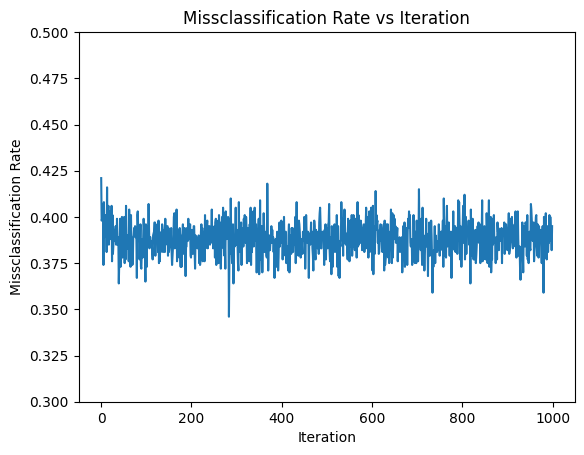

In [41]:
total = train_features.shape[0]
def misses(features,labels,w,b):
    misses = 0
    for i in range(features.shape[0]):
        if labels[i]*(np.dot(w,features[i])+b) <= 0:
            misses += 1
    return misses

def perceptron_algorithm(features, labels, epochs):
    n_samples, n_features = features.shape
    w = np.zeros(n_features)
    b = 0
    incorrect = []
    
    for epoch in range(epochs):
        errors = 0
        for i in range(n_samples):
            if labels[i] * (np.dot(w, features[i]) + b) <= 0:
                w += labels[i] * features[i]
                b += labels[i]
                errors += 1
        incorrect.append(errors / n_samples)
    return incorrect,w, b


# it does not converged i waited around 25-30 minutes runnig for 1000 iterations



incorrect,w,b = perceptron_algorithm(train_features, train_labels,1000) 
print("w =",w)
print("b =",b)

print("Test Misses",misses(test_features,test_labels,w,b),"out of",test_features.shape[0])

# plot of missclassification rate vs iteration

plt.plot(range(1000),incorrect)
plt.xlabel('Iteration')
plt.ylabel('Missclassification Rate')
plt.title('Missclassification Rate vs Iteration')
plt.ylim(0.3,0.5)
plt.show()

In [23]:
# as disscused in class the bound is (R/gamma)^2 
# where R is the maximum norm of the feature vectors and
# gamma is the minimum value of the dot product of the label and the feature vector

R = np.max(np.linalg.norm(train_features))
gamma = np.min(train_labels*(np.dot(train_features,w)/np.linalg.norm(w)))

print((R//gamma)**2)

226576.0


## Linear SVM & Primal + Dual

In [24]:
import numpy as np
import cvxopt
from cvxopt import matrix, solvers

In [25]:
# Normalizing data
train_features = (train_features - np.mean(train_features, axis=0)) / np.std(train_features, axis=0)
test_features = (test_features - np.mean(test_features, axis=0)) / np.std(test_features, axis=0)

In [26]:
def Primal_SVM(X, y, C=1.0):
    data_size, num_feature = X.shape
    y = y.reshape(-1, 1)

    # Objective function
    n = num_feature + 1 + data_size 
    P = np.zeros((n, n))
    P[:num_feature, :num_feature] = np.eye(num_feature)
    q = np.hstack([np.zeros(num_feature + 1), C * np.ones(data_size)])

    # inequalities constraints
    inq1 = np.hstack([-y * X, -y, -np.eye(data_size)])
    inq2 = np.hstack([np.zeros((data_size, num_feature + 1)), -np.eye(data_size)])
    G = np.vstack([inq1, inq2])
    h = np.hstack([-np.ones(data_size), np.zeros(data_size)])

    # using cvxopt for optimization 

    P = matrix(P)
    q = matrix(q)
    G = matrix(G)
    h = matrix(h)

    sol = solvers.qp(P, q, G, h)
    solution = np.array(sol['x']).flatten()

    w = solution[:num_feature]
    b = solution[num_feature]
    xi = solution[num_feature + 1:]

    return w, b, xi

In [27]:
import numpy as np
from cvxopt import matrix, solvers

def Dual_SVM(X, y, C=1.0):
    data_size, num_feature = X.shape
    y = y.reshape(-1, 1)
    
    # Objective function
    K = X @ X.T
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(data_size))
    
    # Inequality constraints
    G = np.vstack([-np.eye(data_size), np.eye(data_size)])
    h = np.hstack([np.zeros(data_size), C * np.ones(data_size)])
    
    # Equality constraints
    A = matrix(y.reshape(1, -1).astype(float))
    b = matrix(0.0)
    
    # using cvxopt for optimization
    G = matrix(G)
    h = matrix(h)

    sol = solvers.qp(P, q, G, h, A, b)    
    alpha = np.array(sol['x']).flatten()
    w = np.dot((alpha * y.flatten()).T, X)
    
    sv_indices = np.where(alpha > 1e-5)[0]
    b = np.mean(y[sv_indices] - np.dot(X[sv_indices], w))
    
    return w, b, alpha

In [35]:
import time
def predict(X, w, b):
    return np.sign(np.dot(X, w) + b)

start_time_primal = time.time()
w_primal, b_primal, soln = Primal_SVM(train_features, train_labels, 1.0)
predictions_primal = predict(train_features, w_primal, b_primal)
misclassified_primal = np.where(predictions_primal != train_labels)[0]
end_time_primal = time.time()

start_time_dual = time.time()
w_dual, b_dual, soln = Dual_SVM(train_features, train_labels, 1.0)
predictions_dual = predict(train_features, w_dual, b_dual)
misclassified_dual = np.where(predictions_dual != train_labels)[0]
end_time_dual = time.time()

print("misclassified points primal =", len(misclassified_primal))
print("misclassified points dual =", len(misclassified_dual))
print("Time taken for primal SVM =", end_time_primal - start_time_primal)
print("Time taken for dual SVM =", end_time_dual - start_time_dual)

     pcost       dcost       gap    pres   dres
 0: -2.0135e+02  2.9689e+03  1e+04  5e+00  3e+01
 1:  1.8561e+03 -3.0064e+02  3e+03  5e-01  4e+00
 2:  7.9890e+02  5.4816e+02  3e+02  9e-03  6e-02
 3:  7.2089e+02  6.3159e+02  9e+01  3e-03  2e-02
 4:  6.9403e+02  6.6087e+02  3e+01  8e-04  6e-03
 5:  6.8819e+02  6.6701e+02  2e+01  4e-04  3e-03
 6:  6.8193e+02  6.7318e+02  9e+00  1e-04  8e-04
 7:  6.7939e+02  6.7557e+02  4e+00  4e-05  3e-04
 8:  6.7802e+02  6.7685e+02  1e+00  1e-05  8e-05
 9:  6.7752e+02  6.7732e+02  2e-01  1e-06  8e-06
10:  6.7742e+02  6.7741e+02  1e-02  6e-08  4e-07
11:  6.7742e+02  6.7742e+02  2e-04  9e-10  6e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.8609e+02 -2.9814e+03  1e+04  3e+00  4e-13
 1: -5.4159e+02 -2.2256e+03  3e+03  4e-01  3e-13
 2: -5.5341e+02 -8.0510e+02  3e+02  6e-03  2e-13
 3: -6.3286e+02 -7.2272e+02  9e+01  2e-03  2e-13
 4: -6.6122e+02 -6.9458e+02  3e+01  5e-04  3e-13
 5: -6.6720e+02 -6.8849e+02  2e+01  3e-04  3e-1

### Non Seprability points

In [29]:
np.savetxt('inseparable_23684.csv', misclassified_primal, delimiter=',')

## Kernelized SVM

In [38]:
def gaussian_kernel(X1, X2, gamma):
    return np.exp(-gamma * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2)**2)

def Kernelized_SVM(X, y, C=1.0, gamma=0.1):
    m = X.shape[0]
    y = y.flatten()

    # kernel function
    K = gaussian_kernel(X, X, gamma)

    P = matrix(np.outer(y, y) * K, tc='d')
    q = matrix(-np.ones(m), tc='d')
    G = matrix(np.vstack([-np.eye(m), np.eye(m)]), tc='d')
    h = matrix(np.hstack([np.zeros(m), C * np.ones(m)]), tc='d')
    A = matrix(y.reshape(1, -1), tc='d')
    b = matrix(0.0, tc='d')

    # using cvxopt for optimization
    soln = solvers.qp(P, q, G, h, A, b)
    alpha = np.array(soln['x']).flatten()
    
    mask = alpha > 1e-5
    vectors = X[mask]
    alphas = alpha[mask]
    labels = y[mask]
    
    margin = (alpha > 1e-5) & (alpha < C)
    if np.any(margin):
        K_sv = gaussian_kernel(X[margin], X, gamma)
        b = np.mean(y[margin] - np.dot(K_sv, alpha * y))
    else:
        K_sv = gaussian_kernel(vectors, X, gamma)
        b = np.mean(labels - np.dot(K_sv, alpha * y))
    
    return vectors, alphas, labels, b, gamma

In [39]:
def kernel_predict(X_test, vectors, alphas, labels, b, gamma):
    K_test = gaussian_kernel(X_test, vectors, gamma)
    decision = np.dot(K_test, alphas * labels) + b
    return np.sign(decision)

vectors, alphas, labels, b, gamma = Kernelized_SVM(train_features, train_labels, 1.0, 0.1)
predictions_train = kernel_predict(train_features, vectors, alphas, labels, b, gamma)
misclassified_train = np.where(predictions_train != train_labels)[0]

vectors, alphas, labels, b, gamma = Kernelized_SVM(test_features, test_labels, 1.0, 0.1)
predictions_test = kernel_predict(test_features, vectors, alphas, labels, b, gamma)
misclassified_test = np.where(predictions_test != test_labels)[0]

print("misclassified points in train data=", len(misclassified_train))
print("misclassified points in test data=", len(misclassified_test))

     pcost       dcost       gap    pres   dres
 0: -5.0569e+02 -2.5168e+03  1e+04  2e+00  3e-15
 1: -3.8686e+02 -1.6630e+03  1e+03  1e-02  3e-15
 2: -4.4195e+02 -6.3836e+02  2e+02  2e-03  3e-15
 3: -4.9048e+02 -5.3348e+02  4e+01  3e-04  3e-15
 4: -5.0305e+02 -5.1130e+02  8e+00  2e-05  3e-15
 5: -5.0556e+02 -5.0669e+02  1e+00  2e-06  3e-15
 6: -5.0594e+02 -5.0605e+02  1e-01  1e-07  3e-15
 7: -5.0598e+02 -5.0599e+02  4e-03  3e-09  3e-15
 8: -5.0598e+02 -5.0598e+02  1e-04  8e-11  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -8.0534e+01 -4.4517e+02  2e+03  2e+00  8e-16
 1: -6.8431e+01 -2.7773e+02  2e+02  6e-15  9e-16
 2: -7.7891e+01 -1.0737e+02  3e+01  7e-15  8e-16
 3: -8.4757e+01 -9.0300e+01  6e+00  7e-15  8e-16
 4: -8.6227e+01 -8.6951e+01  7e-01  1e-15  9e-16
 5: -8.6458e+01 -8.6508e+01  5e-02  4e-15  9e-16
 6: -8.6477e+01 -8.6479e+01  2e-03  2e-15  9e-16
 7: -8.6478e+01 -8.6478e+01  1e-04  4e-15  8e-16
 8: -8.6478e+01 -8.6478e+01  7e-06  3e-15  1e-1

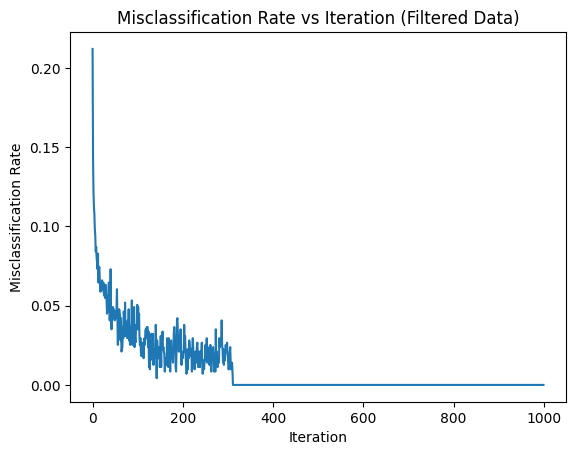

In [43]:
import numpy as np
import matplotlib.pyplot as plt

new_train_features = []
new_train_labels = []
for i in range(len(train_features)):
    if i not in misclassified_primal:
        new_train_features.append(train_features[i])
        new_train_labels.append(train_labels[i])

new_train_features = np.array(new_train_features)
new_train_labels = np.array(new_train_labels)

new_incorrect, w, b = perceptron_algorithm(new_train_features, new_train_labels, 1000)


def misses(features, labels, w, b):
    return np.sum(labels * (np.dot(features, w) + b) <= 0)

# Plot new training curve
plt.plot(range(1000), new_incorrect)
plt.xlabel('Iteration')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate vs Iteration (Filtered Data)')
plt.show()